# Import libraries

In [31]:
import numpy as np
from qiskit import QuantumRegister
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library import GroverOperator

# Implement quantum circuit

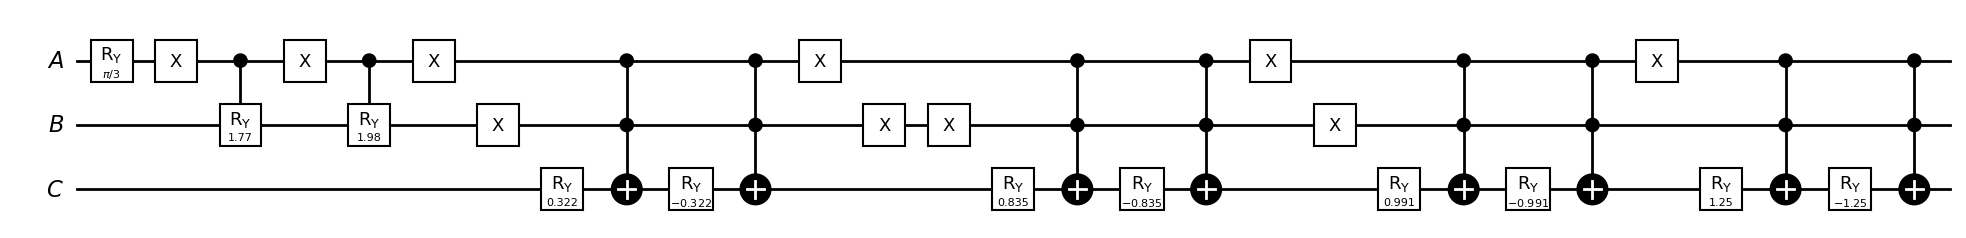

In [32]:
theta_A = 2 * np.arcsin(np.sqrt(0.25))
theta_B_nA = 2 * np.arcsin(np.sqrt(0.6))
theta_B_A = 2 * np.arcsin(np.sqrt(0.7))
theta_C_nBnA = 2 * np.arcsin(np.sqrt(0.1))
theta_C_nBA = 2 * np.arcsin(np.sqrt(0.55))
theta_C_BnA = 2 * np.arcsin(np.sqrt(0.7))
theta_C_BA = 2 * np.arcsin(np.sqrt(0.9))

qrA = QuantumRegister(1, name='A')
qrB = QuantumRegister(1, name='B')
qrC = QuantumRegister(1, name='C')

# Define a 3-qubit quantum circuit
qcA = QuantumCircuit(qrA, qrB, qrC, name="Bayes net big")

# P(A)
qcA.ry(theta_A, 0)

# P(B|-A)
qcA.x(0)
qcA.cry(theta_B_nA, qrA, qrB)
qcA.x(0)

# P(B|A)
qcA.cry(theta_B_A, qrA, qrB)

# P(C|-B,-A)
qcA.x(0)
qcA.x(1)
qcA.mcry(theta_C_nBnA, [qrA[0], qrB[0]], qrC[0])
qcA.x(0)
qcA.x(1)

# P(C|-B,A)
qcA.x(1)
qcA.mcry(theta_C_nBA, [qrA[0], qrB[0]], qrC[0])
qcA.x(1)

# P(C|B,-A)
qcA.x(0)
qcA.mcry(theta_C_BnA, [qrA[0], qrB[0]], qrC[0])
qcA.x(0)

# P(C|B,A)
qcA.mcry(theta_C_BA, [qrA[0], qrB[0]], qrC[0])


qcA.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)

# Run circuit

In [33]:
# Get the Aer simulator backend
simulator_backend = Aer.get_backend('aer_simulator')
def run_circuit(circuit, shots=10_000):
    """
    Run the provided quantum circuit on the Aer simulator backend.

    Parameters:
    - circuit: The quantum circuit to be executed.
    - shots (default=10,000): The number of times the circuit is executed.

    Returns:
    - counts: A dictionary with the counts of each quantum state result.
    """
    # Transpile the circuit for the given backend
    transpiled_circuit = transpile(circuit, simulator_backend)

    # Run the transpiled circuit on the simulator
    job = simulator_backend.run(transpiled_circuit, shots=shots)
    result = job.result()

    # Get the counts of quantum state results
    counts = result.get_counts(transpiled_circuit)

    return counts

# Rejection Sampling

In [34]:
def qrejection_sampling(circ, N, query, evidence, repetitions=5):
    """
    Perform rejection sampling on a quantum circuit.

    Parameters:
    - circ: The quantum circuit to be executed.
    - N: The number of shots for each execution.
    - evidence: The knowledge provided for the sampling.
    - repetitions (default=5): The number of times the circuit is executed and sampled.
    """

    for _ in range(repetitions):
        # Get samples
        counts = run_circuit(circ, shots=N)
        # Count valid samples and valid samples corresponding to query
        nval_samples = 0
        nval_qsamples = 0
        for c_key, c_val in counts.items():
            # Valid samples
            valid = True
            for e_key, e_val in evidence.items():
                if c_key[e_key]!=e_val:
                    valid=False
            if valid:
                nval_samples+=c_val
                # Query samples
                qsample = True
                for q_key, q_val in query.items():
                    if c_key[q_key]!=q_val:
                        qsample=False
                if qsample:
                    nval_qsamples+=c_val

        # Compute and print the ratio
        print(nval_qsamples/nval_samples)
        return 0



# Run rejection sampling

In [35]:
qcCopy = QuantumCircuit(qrA, qrB, qrC, name='Bayes net')
qcCopy.append(qcA, [qrA, qrB, qrC])
qcCopy.measure_all()

query = {1: '1'}
evidence = {0: '0', 2: '0'}
shots = [1_000, 5_000, 10_000, 20_000, 50_000, 100_000]
for N in shots:
    qrejection_sampling(qcCopy,N=N, query=query, evidence=evidence)

0.3231552162849873
0.3351324828263003
0.3456998313659359
0.33620159803318994
0.3323004279179578
0.33134954932707744


# Implement $S_e$

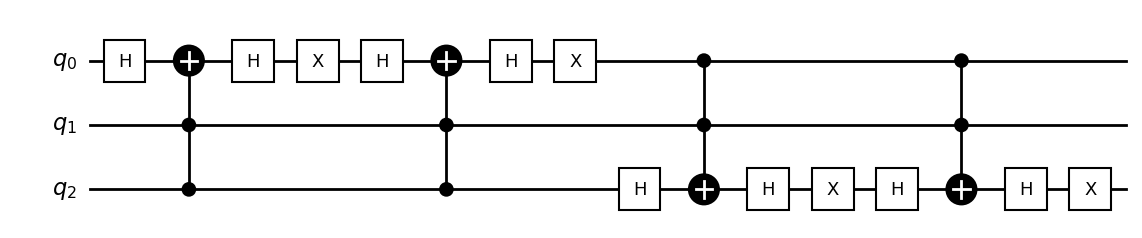

In [36]:
def S_e(observation):
    opSe = QuantumCircuit(3)
    for obs in observation:
        crtls = list({0,1,2} - {obs})
        # multi control z gate
        opSe.h(obs)
        opSe.mcx(crtls, obs)
        opSe.h(obs)
        # x gate
        opSe.x(obs)
        # multi control z gate
        opSe.h(obs)
        opSe.mcx(crtls, obs)
        opSe.h(obs)
        # c gate
        opSe.x(obs)
    return opSe

obs = {0,2}
opSe = S_e(obs)
opSe.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)

# Implement Grover operator

In [37]:
opG = GroverOperator(opSe, qcA)

# Build circuit

In [38]:

qcircG = QuantumCircuit(qrA, qrB, qrC, name='Grover Bayes net')
qcircG.append(qcA, [qrA, qrB, qrC])
qcircG.append(opG, [qrA, qrB, qrC])

qcircG.measure_all()

# Rejection Sampling

In [39]:
query = {1: '1'}
evidence = {0: '0', 2: '0'}
shots = [1_000, 5_000, 10_000, 20_000, 50_000, 100_000]
for N in shots:
    qrejection_sampling(qcircG, N, query=query,evidence=evidence)

0.3409090909090909
0.36637931034482757
0.317351598173516
0.3168433451118963
0.3361462728551336
0.3258426966292135
